# It's Worth A Shot... 
### Urban Density, Endogenous Vaccination Decisions, and Dynamics of Infectious Disease

Data Analysis Notebook <br>
Programmer: Andrew Souther <br>
Date: December 2020

To begin, we import all the packages we need. We use pandas for data manipulation, matplotlib for visualization, and econtools for econometrics work. csv and all the following packages are needed to clean the network data. 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
#import econtools.metrics as mt


import csv
import networkx as nx
from networkx.algorithms import community

We will also define a few helpful functions to make repetitive data tasks a bit cleaner. 

In [2]:
#this function imports an experiment data log file and performs some simple cleaning
def import_and_clean(filepath):
    
    df = pd.read_json(filepath, lines=True)
    
    df["proportion_vacc"] = 1 - (df["unvaccinated"] / df["hub_size"])
    df["proportion_inf"] = (df["recovered"] / df["hub_size"]) 
    df["hub_id"] = df["hub"].astype(str) + df["inst_unique_id"] #generate a unique id for each hub

    return df


#this function builds a dataframe of "steady-state" values, averaged for each hub over the last five seasons
def collapse_steady_state(df):
    
    df_last5 = df.query("season>=20")

    #collapse the data to the hub level, averaging over the last 5 seasons
    df_hubs = df_last5[["proportion_inf", 
                          "proportion_vacc", 
                          "homophily", 
                          "hub_density",
                          "cost_of_infection",
                          "hub_id"]].groupby(["hub_id"]).mean()
    return df_hubs


#this function imports and cleans the raw network data
def import_network_data(filepath, simulation_id):
    network_df = pd.read_json(filepath, lines=True)
    network_df = network_df[network_df["simulation_id"]==simulation_id]
    
    edges_df = network_df.loc[network_df["data_flag"] == "network"]
    edges_df = edges_df[["source", "target"]]

    nodes_df = network_df.loc[network_df["data_flag"] == "hub"]
    nodes_df = nodes_df[["agent", "type"]]
    
    return edges_df, nodes_df


#this function takes network data in two pandas dataframes outputs it in a form that Gephi likes
def build_gexf_from_df(edges_df, nodes_df, filepath):
    
    nodes_df.to_csv('network_data/nodelist.csv', index=False)
    edges_df.to_csv('network_data/edgelist.csv', index=False)

    with open('network_data/nodelist.csv', 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[0] for n in nodes] # Get a list of only the node names

    with open('network_data/edgelist.csv', 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e) for e in edgereader][1:] # Retrieve the data
    
    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    hub_dict = {}
    for node in nodes: # Loop through the list, one row at a time
        hub_dict[node[0]] = node[1]

    nx.set_node_attributes(G, hub_dict, 'type')
    nx.write_gexf(G, filepath)

# Test Code

In [3]:
base_df = import_and_clean("experiment_data.log")
base_df = base_df.loc[base_df["data_flag"] == "seasonal_data"]
print(base_df.shape)
base_df.head()

(250, 17)


,hub,hub_size,hub_density,recovered,unvaccinated,season,transmission_rate,homophily,prob_vacc_choice,recovery_rate,incubation_period,cost_of_infection,inst_unique_id,data_flag,proportion_vacc,proportion_inf,hub_id
0,0,80,8,63,72,0,0.03,0.89,0.08,0.08,3,1,I2021-08-07 13:21:51.87899558093955,seasonal_data,0.1000,0.7875,0I2021-08-07 13:21:51.87899558093955
1,1,80,8,63,72,0,0.03,0.89,0.08,0.08,3,1,I2021-08-07 13:21:51.87899558093955,seasonal_data,0.1000,0.7875,1I2021-08-07 13:21:51.87899558093955
2,2,80,8,65,73,0,0.03,0.89,0.08,0.08,3,1,I2021-08-07 13:21:51.87899558093955,seasonal_data,0.0875,0.8125,2I2021-08-07 13:21:51.87899558093955
3,3,80,8,51,67,0,0.03,0.89,0.08,0.08,3,1,I2021-08-07 13:21:51.87899558093955,seasonal_data,0.1625,0.6375,3I2021-08-07 13:21:51.87899558093955
4,4,80,8,64,71,0,0.03,0.89,0.08,0.08,3,1,I2021-08-07 13:21:51.87899558093955,seasonal_data,0.1125,0.8000,4I2021-08-07 13:21:51.87899558093955


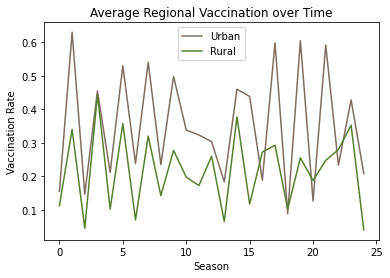

In [4]:
urban_grouped = base_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = base_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index


urban_grouped = base_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = base_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index


plt.plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label='Urban')
plt.plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label='Rural')
plt.title("Average Regional Vaccination over Time") 
plt.xlabel("Season")
plt.ylabel("Vaccination Rate")
plt.legend(loc="best")

### Preparing Network Data for Visualization

We generate our network visualizations using Gephi, not Python. But we still need to shape the raw data into the right format for export to Gephi. 

In [5]:
#import the data and manipulate the dataframes into the right structure
edges99, nodes99 = import_network_data("experiment_data_logs/network_vis_data.log", 1)
edges89, nodes89 = import_network_data("experiment_data_logs/network_vis_data.log", 2)
edges79, nodes79 = import_network_data("experiment_data_logs/network_vis_data.log", 3)

#take a look at one of the dfs
nodes79.head()

ValueError: Expected object or value

Export the network data into a .gexf format.

In [ ]:
build_gexf_from_df(edges99, nodes99, "network_data/99homophily.gexf")
build_gexf_from_df(edges89, nodes89, "network_data/89homophily.gexf")
build_gexf_from_df(edges79, nodes79, "network_data/79homophily.gexf")

### Generating the Visualization for Steady State with Base Parameters

In [ ]:
base_df = import_and_clean("experiment_data_logs/base_parameter_data.log")
base_df = base_df.loc[base_df["data_flag"] == "seasonal_data"]
print(base_df.shape)
base_df.head()

In [ ]:
urban_grouped = base_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = base_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index


urban_grouped = base_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = base_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index


plt.plot(x, urban_grouped["proportion_vacc"], color='#7f6d5f', label='Urban')
plt.plot(x, rural_grouped["proportion_vacc"], color='#557f2d', label='Rural')
plt.title("Average Regional Vaccination over Time") 
plt.xlabel("Season")
plt.ylabel("Vaccination Rate")
plt.legend(loc="best")

In [ ]:
urban_grouped = base_df.query("hub_density==12").groupby(["season"]).mean()
rural_grouped = base_df.query("hub_density==8").groupby(["season"]).mean()
x = urban_grouped.index


plt.plot(x, urban_grouped["proportion_inf"], color='#7f6d5f', label='Urban')
plt.plot(x, rural_grouped["proportion_inf"], color='#557f2d', label='Rural')
plt.title("Average Regional Infection over Time") 
plt.xlabel("Season")
plt.ylabel("Infection Rate")
plt.legend(loc="best")

### Experiment 1: The Effect of Homophily

First, import the data and generate two useful variables.

In [ ]:
df1 = import_and_clean("experiment_data_logs/homophily_test_10_26.log")
print(df1.shape)
df1.head()

Before any data analysis, we want to visualize these epidemics. For this experiment, we need six new dataframes to build some line plots. We divide the data into six subsets based on homophily and hub contact rate. Then, for each epidemic season, we average all the data over every hub. 

In [ ]:
urban_99_grouped = df1.query("homophily==.99 and hub_density==12").groupby(["season"]).mean()
rural_99_grouped = df1.query("homophily==.99 and hub_density==8").groupby(["season"]).mean()

urban_89_grouped = df1.query("homophily==.89 and hub_density==12").groupby(["season"]).mean()
rural_89_grouped = df1.query("homophily==.89 and hub_density==8").groupby(["season"]).mean()

urban_79_grouped = df1.query("homophily==.79 and hub_density==12").groupby(["season"]).mean()
rural_79_grouped = df1.query("homophily==.79 and hub_density==8").groupby(["season"]).mean()


#let's take a look at one of the dataframes for good measure
urban_99_grouped.head()

#### Experiment 1, Visulization

Build three line plots to compare urban vs. rural vaccination rates across the three degrees of homophily.

In [ ]:
#build the basic structure of our line plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)
x = urban_99_grouped.index

urban_list = [urban_99_grouped, urban_89_grouped, urban_79_grouped]
rural_list = [rural_99_grouped, rural_89_grouped, rural_79_grouped]
homophily_list = ["0.99","0.89","0.79"]

#iterate through these lists and visualize the vaccination rates
for i in range(3):
    axes[i].plot(x, urban_list[i]["proportion_vacc"], color='#7f6d5f', label='Urban')
    axes[i].plot(x, rural_list[i]["proportion_vacc"], color='#557f2d', label='Rural')
    axes[i].set_title("Avg Regional Vaccination over Time, Homophily = "+ homophily_list[i]) 
    axes[i].set_xlabel("Season")
    axes[i].set_ylabel("Vaccination Rate")
    axes[i].legend(loc="best")

Build similar graphs for infection rates

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)

urban_list = [urban_99_grouped, urban_89_grouped, urban_79_grouped]
rural_list = [rural_99_grouped, rural_89_grouped, rural_79_grouped]
homophily_list = ["0.99","0.89","0.79"]

#iterate through these lists and visualize the vaccination rates
for i in range(3):
    axes[i].plot(x, urban_list[i]["proportion_inf"], color='#7f6d5f', label='Urban')
    axes[i].plot(x, rural_list[i]["proportion_inf"], color='#557f2d', label='Rural')
    axes[i].set_title("Avg Regional Infection over Time, Homophily = "+ homophily_list[i]) 
    axes[i].set_xlabel("Season")
    axes[i].set_ylabel("Infection Rate")
    axes[i].legend(loc="best")
    

#### Experiment 1, Summary Statistics

In [ ]:
#find average values for each hub over the last five seasons
exp1_hubs = collapse_steady_state(df1)

#clean up some of the variable names for the table
exp1_hubs["Percent Vaccinated"] = exp1_hubs["proportion_vacc"]*100
exp1_hubs["Percent Infected"] = exp1_hubs["proportion_inf"]*100
exp1_hubs = exp1_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})

#build table 1
table1 = exp1_hubs.groupby(["Homophily", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std'],
                                                                  "Percent Vaccinated": ['mean', 'std']}).round(2)
#export table1 to csv and display it
table1.to_csv("tables\homophily_exp_table.csv")
table1

#### Experiment 1, Difference in Differences Estimation

In [ ]:
exp1_dum = pd.get_dummies(exp1_hubs[["Hub Contact Rate", "Homophily"]], columns=["Hub Contact Rate", "Homophily"])
exp1_dum = exp1_dum.rename(columns={"Hub Contact Rate_8": "Rural",
                                "Hub Contact Rate_12": "Urban"})

reg1 = pd.concat([exp1_dum, exp1_hubs], axis=1) 

df_79vs99 = reg1.query("Homophily!=0.89")
df_79vs99["Homophily_0.99:Urban"] = df_79vs99["Homophily_0.99"]*df_79vs99["Urban"]


x = ["Homophily_0.99", "Urban", "Homophily_0.99:Urban"]
y = "Percent Vaccinated"
results = mt.reg(df_79vs99, y, x)

print(results)

### Experiment 2: The Effect of Density

In [ ]:
df2 = import_and_clean("experiment_data_logs/density_test_10_27.log")
print(df2.shape)
df2.head()

For this experiment, we need five  dataframes to build  line plots. We divide the data into five subsets based on hub contact rate. Then, for each epidemic season, we average all the data over every hub. 

In [ ]:
#find the datapoints where density is 6 and 14
df_14_grouped = df2.query("hub_density==14").groupby(["season"]).mean()
df_6_grouped = df2.query("hub_density==6").groupby(["season"]).mean()

#find the next set of datapoints where density is 8 and 12
df_12_grouped = df2.query("hub_density==12").groupby(["season"]).mean()
df_8_grouped = df2.query("hub_density==8").groupby(["season"]).mean()

#last, find the data where density is 10
df_10_grouped = df2.query("hub_density==10").groupby(["season"]).mean()

#let's take a look at one of the dataframes
print(df_14_grouped.shape)
df_14_grouped.head()

#### Experiment 2, Visulization

Build three line plots to compare urban vs. rural vaccination rates across the three contact rate treatments.

In [ ]:
#Build the basic structure of the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)
x = df_14_grouped.index

axes[0].plot(x, df_14_grouped["proportion_vacc"], color='#7f6d5f', label='Urban: 14 contacts')
axes[0].plot(x, df_6_grouped["proportion_vacc"], color='#557f2d', label='Rural: 6 contacts')
axes[0].set_title("Regional Vaccination over Time: 14 vs 6 Contact Rate")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Average Vaccination Rate")
axes[0].legend(loc="best")

axes[1].plot(x, df_12_grouped["proportion_vacc"], color='#7f6d5f', label='Urban: 12 contact')
axes[1].plot(x, df_8_grouped["proportion_vacc"], color='#557f2d', label='Rural: 8 contacts')
axes[1].set_title("Regional Vaccination over Time: 12 vs 8 Contact Rate")
axes[1].set_xlabel("Season")
axes[1].legend(loc="best")

axes[2].plot(x, df_10_grouped["proportion_vacc"], color='#7f6d5f', label='10 contacts')
axes[2].set_title("Regional Vaccination over Time: 10 Contact Rate")
axes[2].set_xlabel("Season")
axes[1].legend(loc="best")

Build similar graphs for infection rates

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)
axes[0].plot(x, df_14_grouped["proportion_inf"], color='#7f6d5f', label='Urban: 14 contacts')
axes[0].plot(x, df_6_grouped["proportion_inf"], color='#557f2d', label='Rural: 6 contacts')
axes[0].set_title("Regional Infection over Time: 14 vs 6 Contact Rate")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Average Infection Rate")
axes[0].legend(loc="best")

axes[1].plot(x, df_12_grouped["proportion_inf"], color='#7f6d5f', label='Urban: 12 contact')
axes[1].plot(x, df_8_grouped["proportion_inf"], color='#557f2d', label='Rural: 8 contacts')
axes[1].set_title("Regional Infection over Time: 12 vs 8 Contact Rate")
axes[1].set_xlabel("Season")
axes[1].legend(loc="best")

axes[2].plot(x, df_10_grouped["proportion_inf"], color='#7f6d5f', label='10 contacts')
axes[2].set_title("Regional Infection over Time: 10 Contact Rate")
axes[2].set_xlabel("Season")
axes[1].legend(loc="best")

#### Experiment 2, Summary Statistics

In [ ]:
#find average values for each hub over the last five seasons
exp2_hubs = collapse_steady_state(df2)

#clean up some of the variable names for the table
exp2_hubs["Percent Vaccinated"] = exp2_hubs["proportion_vacc"]*100
exp2_hubs["Percent Infected"] = exp2_hubs["proportion_inf"]*100
exp2_hubs = exp2_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})

#create a variable for each treatment
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==6) | (exp2_hubs["Hub Contact Rate"]==14), "Treatment"] = "A"
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==8) | (exp2_hubs["Hub Contact Rate"]==12), "Treatment"] = "B"
exp2_hubs.loc[(exp2_hubs["Hub Contact Rate"]==10), "Treatment"] = "C"

#build table 2
table2 = exp2_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std'],
                                                                  "Percent Vaccinated": ['mean', 'std','count']}).round(2)
#export table2 to csv and display it
table2.to_csv("tables\contact_rate_exp_table.csv")
table2

### Experiment 3: The Effect of Infection Cost

In [ ]:
df3 = import_and_clean("experiment_data_logs/cost_test_11_3.log")
print(df3.shape)
df3.head()

Divide the data into six subsets based on the cost of infection and hub density. Average values over all the hubs for each season. These dataframes will be useful for the line plots below.

In [ ]:
urban_2_grouped = df3.query("cost_of_infection==2 and hub_density==12").groupby(["season"]).mean()
rural_2_grouped = df3.query("cost_of_infection==2 and hub_density==8").groupby(["season"]).mean()

urban_3_grouped = df3.query("cost_of_infection==3 and hub_density==12").groupby(["season"]).mean()
rural_3_grouped = df3.query("cost_of_infection==3 and hub_density==8").groupby(["season"]).mean()

urban_4_grouped = df3.query("cost_of_infection==4 and hub_density==12").groupby(["season"]).mean()
rural_4_grouped = df3.query("cost_of_infection==4 and hub_density==8").groupby(["season"]).mean()


#let's take a look at one of the dataframes for good measure
urban_4_grouped.head()

#### Experiment 3, Visualizations

In [ ]:
#build the basic structure of our line plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)
x = urban_2_grouped.index

urban_list2 = [urban_2_grouped, urban_3_grouped, urban_4_grouped]
rural_list2 = [rural_2_grouped, rural_3_grouped, rural_4_grouped]
cost_list = ["2","3","4"]

#iterate through these lists and visualize the vaccination rates
for i in range(3):
    axes[i].plot(x, urban_list2[i]["proportion_vacc"], color='#7f6d5f', label='Urban')
    axes[i].plot(x, rural_list2[i]["proportion_vacc"], color='#557f2d', label='Rural')
    axes[i].set_title("Avg Regional Vaccination over Time, Infection Cost of "+ cost_list[i]) 
    axes[i].set_xlabel("Season")
    axes[i].legend(loc="best")
    
    if i==0:
        axes[i].set_ylabel("Vaccination Rate")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,4), sharey=True)

#iterate through these lists and visualize the vaccination rates
for i in range(3):
    axes[i].plot(x, urban_list2[i]["proportion_inf"], color='#7f6d5f', label='Urban')
    axes[i].plot(x, rural_list2[i]["proportion_inf"], color='#557f2d', label='Rural')
    axes[i].set_title("Avg Regional Infection over Time, Infection Cost of "+ cost_list[i]) 
    axes[i].set_xlabel("Season")
    axes[i].legend(loc="best")
    
    if i==0:
            axes[i].set_ylabel("Infection Rate")

#### Experiment 3, Summary Statistics

In [ ]:
#find average values for each hub over the last five seasons
exp3_hubs = collapse_steady_state(df3)

#clean up some of the variable names for the table
exp3_hubs["Percent Vaccinated"] = exp3_hubs["proportion_vacc"]*100
exp3_hubs["Percent Infected"] = exp3_hubs["proportion_inf"]*100
exp3_hubs = exp3_hubs.rename(columns={"cost_of_infection": "Cost of Infection",
                                    "hub_density": "Hub Contact Rate"})


#build table 3
table3 = exp3_hubs.groupby(["Cost of Infection", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std'],
                                                                  "Percent Vaccinated": ['mean', 'std','count']}).round(2)
#export table3 to csv and display it
table3.to_csv("tables\infection_cost.csv")
table3

### Experiment 4: The Effect of Population Difference

In this experiment, we need to import two dataframes. df4a will include all of our data where population sizes are 140 and 60; df4b will include all of our data where population size is constant at 100. 

In [ ]:
df4a = import_and_clean("experiment_data_logs/pop_test_a_11_8.log")
print(df4a.shape)
df4a.head()

In [ ]:
df4b = import_and_clean("experiment_data_logs/pop_test_b_11_9.log")
print(df4b.shape)
df4b.head()

#### Experiment 4, Visualization

In [ ]:
x = range(25)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (18,15), sharey=True, sharex=True)

df_list = [df4a,df2,df4b]
pop_size_list = [(140,60), (120,80), (100,100)]
contact_rate_list = [(14,6), (12,8), (10,10)]


#first, we want to loop through every dataframe in the df_list
for i in range(3):
    pop_df = df_list[i]
    urban_pop_size = pop_size_list[i][0]
    rural_pop_size = pop_size_list[i][1]
    
    #then, we want to loop through every possible combination of contact rates in taht df
    for j in range(3):
        
        #find the urban contact rate and the rural contact rate
        urban_cr = contact_rate_list[j][0]
        rural_cr = contact_rate_list[j][1]
        
        #create subsets of the data for urban and rural. Then collapse on season averages
        urban_df = pop_df.query(f"hub_density=={urban_cr}").groupby(["season"]).mean()
        rural_df = pop_df.query(f"hub_density=={rural_cr}").groupby(["season"]).mean()
        
        if urban_cr!=rural_cr: #if urban and rural contact rates are different, plot two lines
            axes[i,j].plot(x, urban_df["proportion_vacc"], color='#7f6d5f', label=f'Urban: {urban_pop_size} agents')
            axes[i,j].plot(x, rural_df["proportion_vacc"], color='#557f2d', label=f'Rural: {rural_pop_size} agents')
            axes[i,j].legend(loc="best")
            if i==0:
                axes[i,j].set_title(f"Regional Vaccination over Time: {urban_cr} vs {rural_cr} Contact Rate")
            
        else: #if the urban and rual contact rates are the same (10), plot only one line
            axes[i,j].plot(x, urban_df["proportion_vacc"], color='#7f6d5f', label='All 10 contact rate')
            axes[i,j].legend(loc="best")
            if i==0: 
                axes[i,j].set_title(f"Regional Vaccination over Time: 10 Contact Rate")
                
        if j==0: #if the plot is on the left column, set a y label
                axes[i,j].set_ylabel("Average Vaccination Rate")
        if i==2: #if the plot is on the bottom row, set an x label
                axes[i,j].set_xlabel("Season")

In [ ]:
x = range(25)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (18,15), sharey=True, sharex=True)

#first, we want to loop through every dataframe in the df_list
for i in range(3):
    pop_df = df_list[i]
    urban_pop_size = pop_size_list[i][0]
    rural_pop_size = pop_size_list[i][1]
    
    #then, we want to loop through every possible combination of contact rates in taht df
    for j in range(3):
        
        #find the urban contact rate and the rural contact rate
        urban_cr = contact_rate_list[j][0]
        rural_cr = contact_rate_list[j][1]
        
        #create subsets of the data for urban and rural. Then collapse on season averages
        urban_df = pop_df.query(f"hub_density=={urban_cr}").groupby(["season"]).mean()
        rural_df = pop_df.query(f"hub_density=={rural_cr}").groupby(["season"]).mean()
        
        if urban_cr!=rural_cr: #if urban and rural contact rates are different, plot two lines
            axes[i,j].plot(x, urban_df["proportion_inf"], color='#7f6d5f', label=f'Urban: {urban_pop_size}')
            axes[i,j].plot(x, rural_df["proportion_inf"], color='#557f2d', label=f'Rural: {rural_pop_size}')
            axes[i,j].legend(loc="best")
            if i==0:
                axes[i,j].set_title(f"Regional Infection over Time: {urban_cr} vs {rural_cr} Contact Rate")
            
        else: #if the urban and rual contact rates are the same (10), plot only one line
            axes[i,j].plot(x, urban_df["proportion_inf"], color='#7f6d5f', label='All 10 contact rate')
            axes[i,j].legend(loc="best")
            if i==0: 
                axes[i,j].set_title(f"Regional Infection over Time: 10 Contact Rate")
                
        if j==0: #if the plot is on the left column, set a y label
                axes[i,j].set_ylabel("Average Infection Rate")
        if i==2: #if the plot is on the bottom row, set an x label
                axes[i,j].set_xlabel("Season")

#### Experiment 4, Summary Statistics

This table looks slightly different from the previous ones. First we build table 4(a), about vaccination rates. 

In [ ]:
exp4a_hubs = collapse_steady_state(df4a)
exp4b_hubs = collapse_steady_state(df4b)

#clean up some of the variable names for the table
exp4a_hubs["Percent Vaccinated"] = exp4a_hubs["proportion_vacc"]*100
exp4a_hubs["Percent Infected"] = exp4a_hubs["proportion_inf"]*100
exp4a_hubs = exp4a_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})

exp4b_hubs["Percent Vaccinated"] = exp4b_hubs["proportion_vacc"]*100
exp4b_hubs["Percent Infected"] = exp4b_hubs["proportion_inf"]*100
exp4b_hubs = exp4b_hubs.rename(columns={"homophily": "Homophily",
                                    "hub_density": "Hub Contact Rate"})


#create a variable for each treatment
exp4a_hubs.loc[(exp4a_hubs["Hub Contact Rate"]==6) | (exp4a_hubs["Hub Contact Rate"]==14), "Treatment"] = "A"
exp4a_hubs.loc[(exp4a_hubs["Hub Contact Rate"]==8) | (exp4a_hubs["Hub Contact Rate"]==12), "Treatment"] = "B"
exp4a_hubs.loc[(exp4a_hubs["Hub Contact Rate"]==10), "Treatment"] = "C"

exp4b_hubs.loc[(exp4b_hubs["Hub Contact Rate"]==6) | (exp4b_hubs["Hub Contact Rate"]==14), "Treatment"] = "A"
exp4b_hubs.loc[(exp4b_hubs["Hub Contact Rate"]==8) | (exp4b_hubs["Hub Contact Rate"]==12), "Treatment"] = "B"
exp4b_hubs.loc[(exp4b_hubs["Hub Contact Rate"]==10), "Treatment"] = "C"


#build table 4a
vacc_2 = exp2_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Vaccinated": ['mean', 'std']}).round(2)
vacc_2 = vacc_2.rename(columns={"Percent Vaccinated": "Percent Vaccinated (Pop Size I)"})
vacc_4a = exp4a_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Vaccinated": ['mean', 'std']}).round(2)
vacc_4a = vacc_4a.rename(columns={"Percent Vaccinated": "Percent Vaccinated (Pop Size II)"})
vacc_4b = exp4b_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Vaccinated": ['mean', 'std']}).round(2)
vacc_4b = vacc_4b.rename(columns={"Percent Vaccinated": "Percent Vaccinated (Pop Size III)"})

#concatenate the tables together
table4a = pd.concat([vacc_2,vacc_4a,vacc_4b], axis=1)

#export table4a to csv and display it
table4a.to_csv("tables\pop_size_vacc_table.csv")
table4a

Now, we want to create the same table as above for infection rates. This will be table 4(b).

In [ ]:
#now we want to create the same table as above for inf rates
#build table 4a
inf_2 = exp2_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std']}).round(2)
inf_2 = inf_2.rename(columns={"Percent Infected": "Percent Infected (Pop Size I)"})
inf_4a = exp4a_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std']}).round(2)
inf_4a = inf_4a.rename(columns={"Percent Infected": "Percent Infected  (Pop Size II)"})
inf_4b = exp4b_hubs.groupby(["Treatment", "Hub Contact Rate"]).agg({"Percent Infected": ['mean', 'std']}).round(2)
inf_4b = inf_4b.rename(columns={"Percent Infected": "Percent Infected (Pop Size III)"})

#concatenate the tables together
table4b = pd.concat([inf_2,inf_4a,inf_4b], axis=1)

#export table4a to csv and display it
table4b.to_csv("tables\pop_size_inf_table.csv")
table4b